In [1]:
import sys
sys.path.append('../../')

In [2]:

%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# from fit_and_predict import fit_and_predict
from tqdm import tqdm

In [3]:
import numpy.random as npr
import numpy.linalg as npl

from scipy.stats import norm as normal
from scipy.stats import laplace as laplace
from scipy.optimize import curve_fit

In [4]:
aggregate_by_state = False
# outcome_type = 'cases'

In [5]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../../data/')
# df = df.sort_values('#Deaths_03-30-2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [6]:
df["State"]

1843          New York
1860          New York
1822          New York
1850          New York
1304          Michigan
             ...      
1054          Kentucky
1942    North Carolina
249           Colorado
1940    North Carolina
3140               NaN
Name: State, Length: 3141, dtype: object

In [7]:
def sum_lists(list_of_lists, start_idx=0, end_idx=-1):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    if end_idx == -1:
        return list(sum_arr[start_idx:])
    else:
        return list(sum_arr[start_idx:end_idx])
aggregate_by_state = True
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('State').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('State').cases.agg(sum_lists).to_frame()
    state_pop_df = df.groupby('State').PopulationEstimate2018.agg(sum).to_frame()
    sdf =  pd.concat([state_cases_df,state_deaths_df, state_pop_df],axis =1 )

In [8]:
death_keys = []
i = 0
for key in df.keys():
    if '#Death' in key:
        death_keys.append(key)
        if i<5:
            print(key)
            i+=1

#Deaths_01-22-2020
#Deaths_01-23-2020
#Deaths_01-24-2020
#Deaths_01-25-2020
#Deaths_01-26-2020


In [9]:
sdf = sdf.reset_index()
sdf.keys()

Index(['State', 'cases', 'deaths', 'PopulationEstimate2018'], dtype='object')

In [10]:
sdf = sdf.rename(columns={"State": "state", "PopulationEstimate2018": 'population' })
len(death_keys), len(sdf.iloc[0].deaths)

(98, 98)

## IHME Mar 25 / Apr 5

- we have to adjust for prediction start dates for different starting points so we 

### Fix the dates from march 1st to Arpil 27th

In [813]:
from datetime import timedelta

In [248]:
start_date = pd.to_datetime('03-01-2020').strftime('%m-%d-%Y')
end_date = pd.to_datetime('04-27-2020').strftime('%m-%d-%Y') #pd.to_datetime(death_keys[-1][8:]).strftime('%m-%d-%Y')

In [249]:
sdf_start_idx = None
sdf_end_idx = None

for j, key in enumerate(death_keys):
    if start_date in key:
        print(key, j)
        sdf_start_idx = j
    if end_date in key:
        print(key, j)
        sdf_end_idx = j+1

if sdf_start_idx == None:
    sdf_start_idx = 0
if sdf_end_idx == None:
    sdf_end_idx = -1
    
state_deaths_df = df.groupby('State').deaths.agg(sum_lists, sdf_start_idx, sdf_end_idx).to_frame()
state_cases_df = df.groupby('State').cases.agg(sum_lists, sdf_start_idx, sdf_end_idx).to_frame()
state_pop_df = df.groupby('State').PopulationEstimate2018.agg(sum).to_frame()
sdf =  pd.concat([state_cases_df,state_deaths_df, state_pop_df], axis =1 ).reset_index()
sdf = sdf.rename(columns={"State": "state", "PopulationEstimate2018": 'population' })
sdf.head()

#Deaths_03-01-2020 39
#Deaths_04-27-2020 96


,state,cases,deaths,population
0,Alabama,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 11, 22...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4887871.0
1,Arizona,"[1, 1, 1, 1, 1, 2, 4, 4, 6, 6, 10, 10, 10, 12,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7171646.0
2,Arkansas,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 6, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3013825.0
3,California,"[22, 30, 34, 48, 62, 79, 98, 110, 173, 200, 28...","[2, 2, 2, 3, 3, 4, 4, 4, 5, 6, 7, 7, 7, 7, 9, ...",39557045.0
4,Colorado,"[0, 0, 0, 0, 0, 3, 7, 7, 14, 18, 24, 49, 75, 9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",5695564.0


In [588]:
# for j, key in enumerate(death_keys[sdf_start_idx:sdf_end_idx]):
#     print(key[8:13], sdf[sdf.state=="California"]["deaths"].values[0][j])

### Extract IHME data

In [1554]:
file_name, pred_start = "apr_12.csv", "04-11-2020"

ihme = pd.read_csv(file_name)

ihme = ihme.rename(columns={"location_name": "state", "date": "date_reported"})
ihme["date_reported"] = pd.to_datetime(ihme['date_reported']).dt.strftime('%m-%d-%Y')

ihme.head()

,V1,state,date_reported,allbed_mean,allbed_lower,allbed_upper,ICUbed_mean,ICUbed_lower,ICUbed_upper,InvVen_mean,...,newICU_upper,totdea_mean,totdea_lower,totdea_upper,bedover_mean,bedover_lower,bedover_upper,icuover_mean,icuover_lower,icuover_upper
0,1,Wyoming,01-03-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Wyoming,01-04-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Wyoming,01-05-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Wyoming,01-06-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Wyoming,01-07-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1555]:
start_idx = np.where(ihme[ihme.state=='Texas'].reset_index()["date_reported"] == start_date)[0][0]
end_idx = np.where(ihme[ihme.state=='Texas'].reset_index()["date_reported"] == end_date)[0][0] + 1

pred_start_idx = np.where(ihme[ihme.state=='Alabama'].date_reported == pred_start)[0][0]-start_idx

print(start_date, end_date, pred_start, start_idx, end_idx, pred_start_idx)

ihme_deaths_df = ihme.groupby('state').totdea_mean.agg(get_lists, start_idx, end_idx).to_frame().reset_index()
ihme_deaths_lower_df = ihme.groupby('state').totdea_lower.agg(get_lists, start_idx, end_idx).to_frame().reset_index()
ihme_deaths_upper_df = ihme.groupby('state').totdea_upper.agg(get_lists, start_idx, end_idx).to_frame().reset_index()

ihme_state_df =  pd.merge(ihme_deaths_df, ihme_deaths_lower_df, how='outer', on ='state' )
ihme_state_df =  pd.merge(ihme_state_df, ihme_deaths_upper_df, how='outer', on ='state' )
ihme_state_df = ihme_state_df.rename(columns={"totdea_mean": "model_deaths", "totdea_lower": 'model_lower', "totdea_upper": 'model_upper'})

ihme_state_df =  ihme_state_df.sort_values('state', ascending=True)
ihme_state_df.head(2)

03-01-2020 04-27-2020 04-11-2020 58 116 41


,state,model_deaths,model_lower,model_upper
0,Abruzzo,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Alabama,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [1556]:
if file_name == "apr_27.csv":
    ihme_deaths = ihme_state_df[["state", "model_deaths"]]
    ihme_deaths = ihme_deaths.rename(columns={"model_deaths":"ihme_deaths"})
    
ihme_state_df = ihme_state_df.merge(ihme_deaths, "outer", on="state")
ihme_state_df.head(2)

,state,model_deaths,model_lower,model_upper,ihme_deaths
0,Abruzzo,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Alabama,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [1557]:
merge = pd.merge(ihme_state_df, sdf, 'inner', 'state')
merge.head(4)

,state,model_deaths,model_lower,model_upper,ihme_deaths,cases,deaths,population
0,Alabama,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 11, 22...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4887871.0
1,Arizona,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 2, 4, 4, 6, 6, 10, 10, 10, 12,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7171646.0
2,Arkansas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 6, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3013825.0
3,California,"[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[22, 30, 34, 48, 62, 79, 98, 110, 173, 200, 28...","[2, 2, 2, 3, 3, 4, 4, 4, 5, 6, 7, 7, 7, 7, 9, ...",39557045.0


In [1558]:
merge.state.nunique(), sdf.state.nunique(), ihme_state_df.state.nunique()

(48, 49, 161)

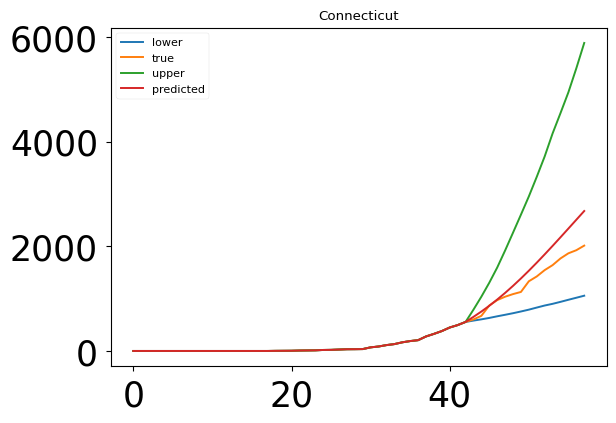

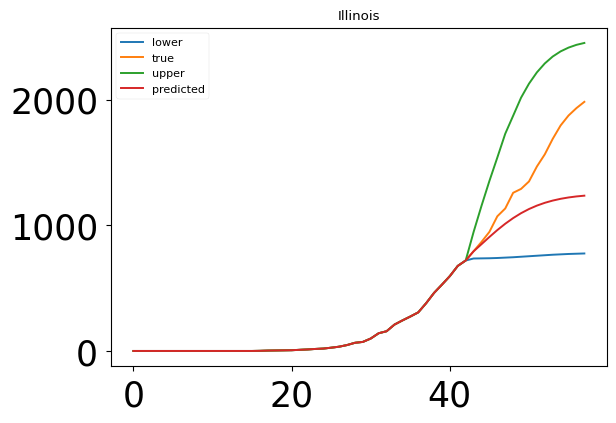

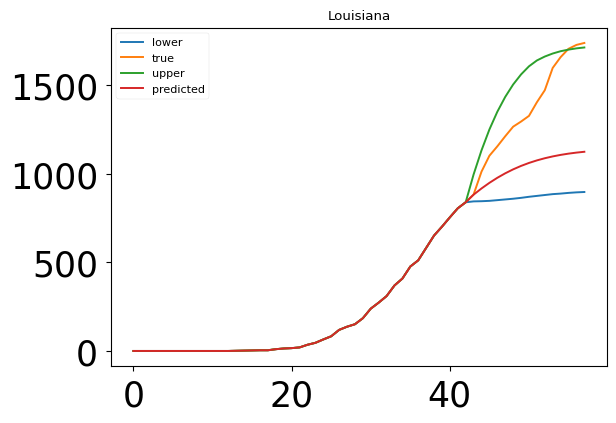

In [1559]:
## plot of bands
for i in [5, 10, 15]:
    plt.plot(merge.iloc[i]["model_lower"], label='lower')
    plt.plot(merge.iloc[i]["ihme_deaths"], label='true')
    plt.plot(merge.iloc[i]["model_upper"], label='upper')
    plt.plot(merge.iloc[i]["model_deaths"], label='predicted')
    plt.legend()
    plt.title(merge.iloc[i]["state"])
    plt.show()

### Our data vs thiers

In [1560]:
# random_idxs = npr.choice(len(merge), 10, replace=False)
# for i in random_idxs:
#     try:
#         plt.plot(np.asarray(merge.iloc[i].ihme_deaths) - np.asarray(merge.iloc[i].deaths), label=merge.iloc[i].state)
#     except:
#         pass
# plt.legend()
# plt.title('Errors between the IHME death data and ours ')
# plt.show()

# plt.scatter(merge[merge.state=='Missouri']["ihme_deaths"].values[0], merge[merge.state=='Missouri']["deaths"].values[0])
# plt.plot([0, 750], [0, 750], linestyle='--', alpha=0.4)
# plt.xlabel('IHME Death Data')
# plt.ylabel('Our Death Data')
# plt.show()

### Coverage can be measured multiple ways

- Freuqentist style: % of states covered daily
- The real Vovk style: % coverage statewise overtime (so far) --> have to look at histogram
- Running Vovk style: % coverage statewise overtime (2 week intervals)--> have to look at histogram

### MEPI has many parameters

- use max of abs(delta), or min-max delta intervals
- number of days in the rolling window
- look ahead (lag in the rolling window) called as shift
- multiplier of the delta

### Take Aways

- min-max intervals are preferred because they are narrower, also errors are often one-sided; however they have slightly worse coverage
- coverage is typically bad if we do not have a multiplier, raising it from 1 to 1.3 has a significant effect, more than changing the window size
- with multiplier around 1.4-1.5, we can also use errors from the past (so basically a few days ahead prediction is possible)
- w = 7, multiplier = 1.5, can do a good job with lag/shift of 5 days with min-max method
- Running average is not that different than overall average, MEPI coverage (across states) tends to get better with time


KeyboardInterrupt: 

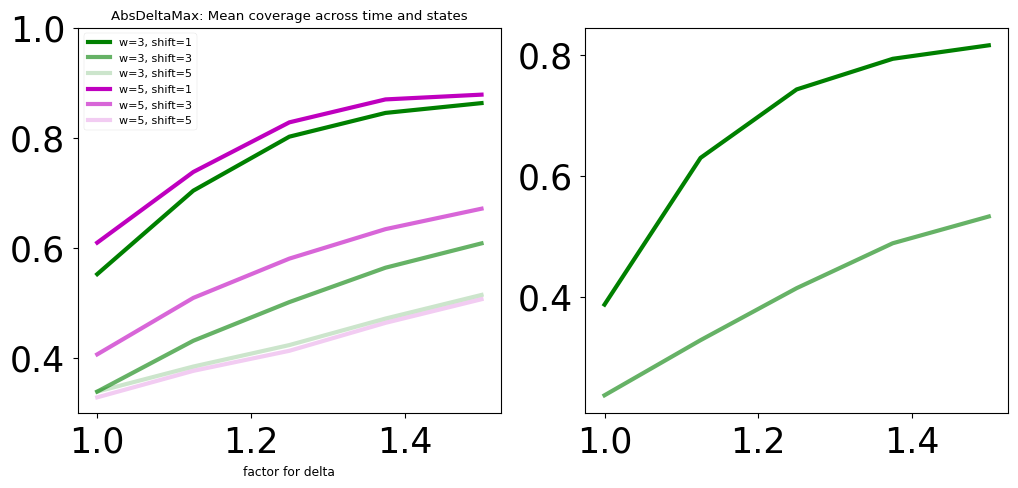

In [1561]:
plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
colors = ['g', 'm']
alphas = [1., 0.6, 0.2]

for i, w in enumerate([3, 5]):
    for j, shift in enumerate([1, 3, 5]):
        values = []
        factors = np.linspace(1., 1.5, 5)
        t0 = max(pred_start_idx+w-shift+1, pred_start_idx+1)
        for factor in factors:
            new_df = compute_mepi_and_converage(merge, pred_start_idx, w, factor, 'abs', shift)

            model_coverage = 1.-np.abs(np.stack(new_df['m_cover'])) 
            mepi_coverage = 1.-np.abs(np.stack(new_df['mepi_cover']))

            values.append(np.mean(mepi_coverage[:, t0:]))
        
        plt.plot(factors, values, label='w=%d, shift=%d'%(w, shift), alpha=alphas[j], color=colors[i], linewidth=3.)
plt.legend()
plt.ylim([0.3, 1.])
plt.xlabel('factor for delta')
plt.title('AbsDeltaMax: Mean coverage across time and states')

plt.subplot(1, 2, 2)
for i, w in enumerate([3, 5]):
    for j, shift in enumerate([1, 3, 5]):
        values = []
        factors = np.linspace(1., 1.5, 5)
        t0 = max(pred_start_idx+w-shift+1, pred_start_idx+1)
        for factor in factors:
            new_df = compute_mepi_and_converage(merge, pred_start_idx, w, factor, 'pos-neg', shift)

            model_coverage = 1.-np.abs(np.stack(new_df['m_cover'])) 
            mepi_coverage = 1.-np.abs(np.stack(new_df['mepi_cover']))

            values.append(np.mean(mepi_coverage[:, t0:]))
        plt.plot(factors, values, label='w=%d, shift=%d'%(w, shift), alpha=alphas[j], color=colors[i], linewidth=3.)
plt.legend()
plt.ylim([0.3, 1.])
plt.xlabel('factor for delta')
plt.title('MinMax: Mean coverage across time and states')
plt.show()


In [ ]:
def compute_mepi_and_converage(df, pred_start_idx, w=5, factor=1.0, method='abs', shift=1):
    new_df = df.copy(deep=True)
    
    for f in ["ihme_del","m_cover", "m_del", "m_del_max", "mepi_lower", "mepi_upper", "mepi_cover"]:
        new_df[f] = [[] for _ in range(len(new_df))]

    pred_start_idx += 1 # to adjust prediction start_date
    for idx in range(len(new_df)):
        cover = -1. * np.array(np.asarray(new_df.iloc[idx].ihme_deaths) <  np.asarray(new_df.iloc[idx].model_lower), dtype=int)
        cover += 1. * np.array(np.asarray(new_df.iloc[idx].ihme_deaths) >  np.asarray(new_df.iloc[idx].model_upper), dtype=int)

        cover_mepi = np.ones_like(cover)
        mepi_lb =  np.zeros_like(cover)
        mepi_ub =  np.zeros_like(cover)
        
        
        ihme_del =np.array((np.asarray(new_df.iloc[idx].model_upper) - np.asarray(new_df.iloc[idx].model_lower)) /  (1.+np.asarray(new_df.iloc[idx].ihme_deaths)), dtype=float) 
        delta = np.array(np.asarray(new_df.iloc[idx].ihme_deaths) /  (1.+np.asarray(new_df.iloc[idx].model_deaths)), dtype=float) -1.
#         norm_del = np.power(1.1, np.arange(0, len(delta)))
        
        del_max = pd.Series(np.abs(delta)).rolling(w).max().shift(shift)
#         del_max = pd.Series(np.abs(delta)/norm_del).rolling(w).max().shift(shift)
#         del_max *= pd.Series(np.power(1.1, np.arange(0, len(delta)))).shift(shift)
        
        del_pos = pd.Series(delta).rolling(w).max().shift(shift)  # can not use today's error
        del_neg = pd.Series(delta).rolling(w).min().shift(shift)  # can not use today's error
        
        death_shift = pd.Series(new_df.iloc[idx].ihme_deaths).shift(shift)
        t0 = pred_start_idx+w-shift+1
        if method!='abs':
            mepi_lb[t0:] = np.around(np.asarray(new_df.iloc[idx].model_deaths)[t0:] * np.maximum(0., np.minimum(1., 1.+factor*del_neg[t0:])))
            mepi_ub[t0:] = np.around(np.asarray(new_df.iloc[idx].model_deaths)[t0:] * (1.+np.maximum(0., factor*del_pos[t0:])))
        else:
            mepi_lb[t0:] = np.around(np.asarray(new_df.iloc[idx].model_deaths)[t0:] * np.maximum(0., 1.-factor*del_max[t0:]))
            mepi_ub[t0:] = np.around(np.asarray(new_df.iloc[idx].model_deaths)[t0:] * (1.+factor*del_max[t0:]))
            
        mepi_lb[t0:] = np.maximum(death_shift[t0:], mepi_lb[t0:])
        cover_mepi[t0:] = -1. * np.array(np.asarray(new_df.iloc[idx].ihme_deaths)[t0:] <  np.asarray(mepi_lb)[t0:], dtype=int)
        cover_mepi[t0:] += 1. * np.array(np.asarray(new_df.iloc[idx].ihme_deaths)[t0:] >  np.asarray(mepi_ub)[t0:], dtype=int)
        
        new_df.at[idx, "ihme_del"] = np.array(ihme_del).flatten()
        
        new_df.at[idx, "m_cover"] = np.array(cover).flatten()
        new_df.at[idx, "m_del"] = np.asarray(delta).flatten()
        new_df.at[idx, "m_del_max"] = np.asarray(del_max).flatten()
        
        new_df.at[idx, "mepi_upper"] = np.asarray(mepi_ub).flatten()
        new_df.at[idx, "mepi_lower"] = np.asarray(mepi_lb).flatten()
        new_df.at[idx, "mepi_cover"] = np.asarray(cover_mepi).flatten()
    return(new_df)

def get_lists(list_of_lists, start_idx=0, end_idx=-1):
    arr = np.array(list(list_of_lists))
    if end_idx == -1:
        return list(arr[start_idx:])
    else:
        return list(arr[start_idx:end_idx])

In [1573]:
w, factor, method, shift = 5, 2., 'abs', 1

t0 = max(pred_start_idx+w-shift+1, pred_start_idx+1)
new_df = compute_mepi_and_converage(merge, pred_start_idx, w, factor, method, shift)

model_coverage = 1.-np.abs(np.stack(new_df['m_cover'])) 
mepi_coverage = 1.-np.abs(np.stack(new_df['mepi_cover']))

### Comparing bands across states

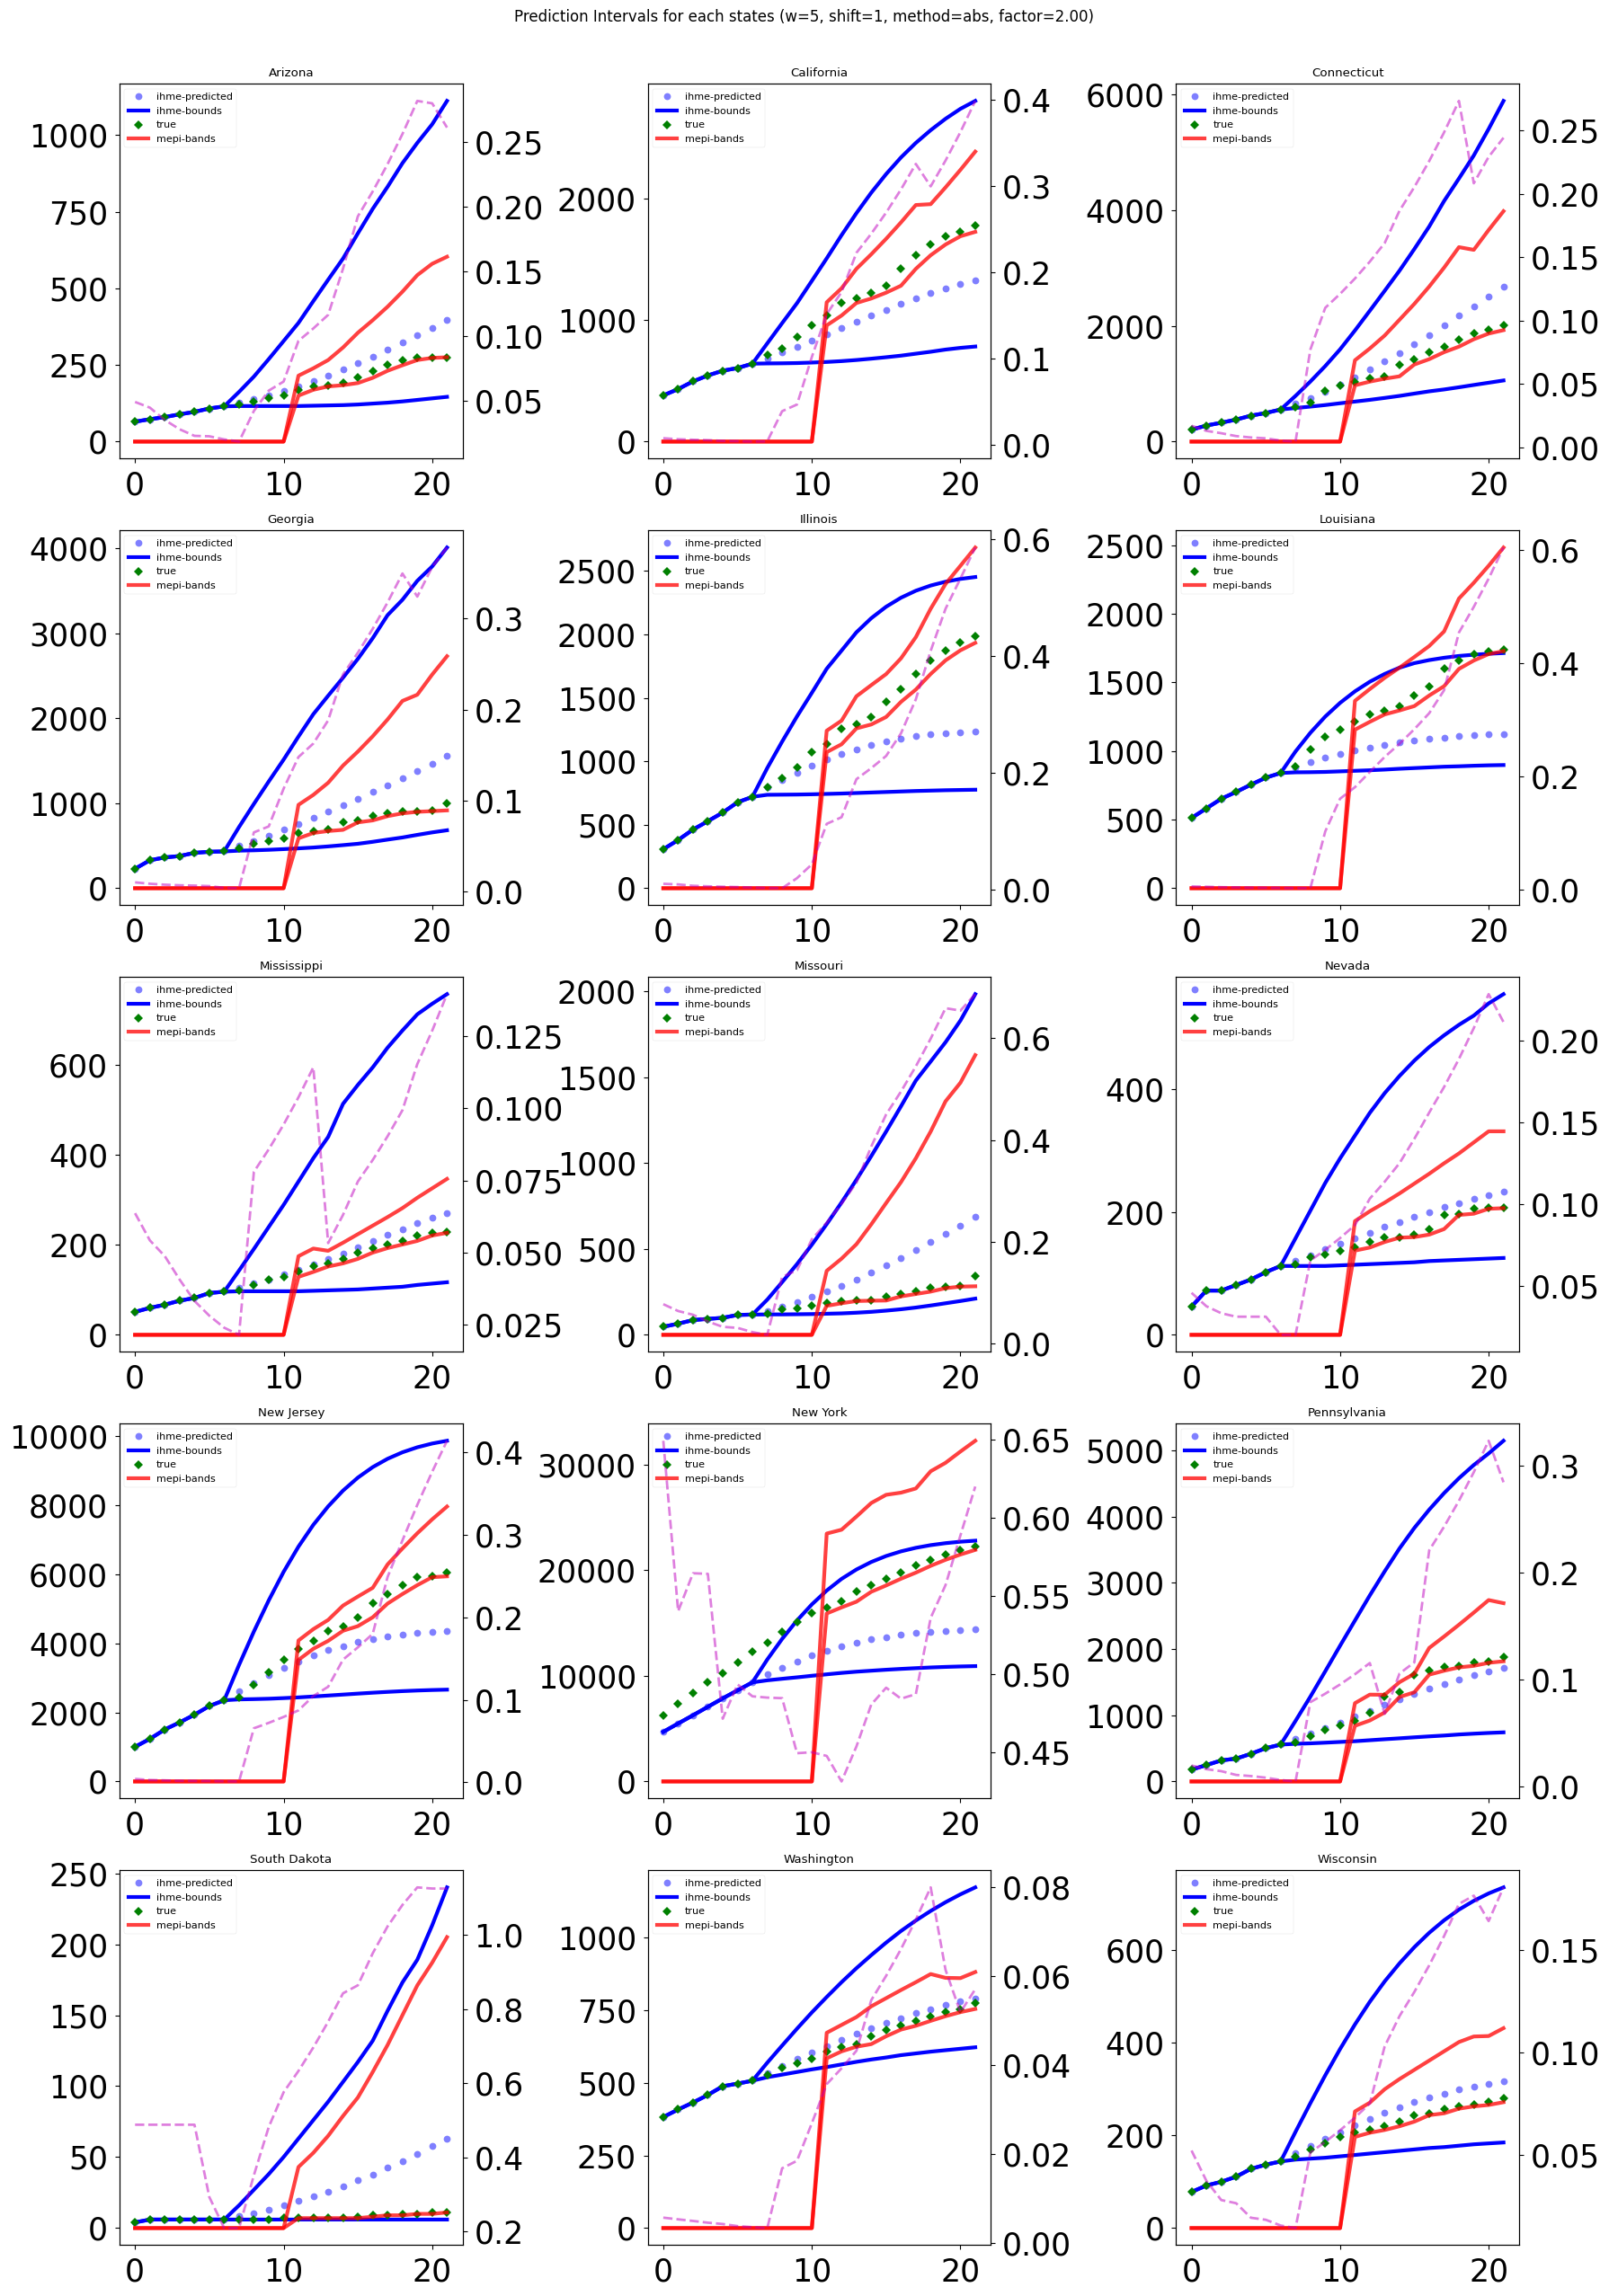

In [1574]:
## plot of bands
# for i in npr.choice(len(new_df), 3, replace=False):
indexes = [1, 3, 5, 8, 10, 15, 21, 22, 25, 27, 29,  35, 38, 44, 46]

# indexes = new_df["state"][np.where(100*model_coverage[:, l:].mean(axis=1)<95)[0]].index
# indexes = indexes[:15]
plt.figure(figsize=[3*6, 5*5])
for j, i in enumerate(indexes):
    plt.subplot(5, 3, j+1)
    plt.plot(new_df.iloc[i]["model_deaths"][pred_start_idx-5:], label='ihme-predicted', 
             marker='o', linestyle='None', color='b', alpha=.5)
    plt.plot(new_df.iloc[i]["model_lower"][pred_start_idx-5:], 
             label='ihme-bounds', 
             color='b', linestyle='-', linewidth=3.)
    plt.plot(new_df.iloc[i]["model_upper"][pred_start_idx-5:], 
#              label='ihme-upper', 
             color='b', linestyle='-', linewidth=3.)

    plt.plot(new_df.iloc[i]["ihme_deaths"][pred_start_idx-5:], label='true', color='g', marker='D', linestyle='None')
    plt.plot(new_df.iloc[i]["mepi_lower"][pred_start_idx-5:], 
             label='mepi-bands', 
             color='r',
             linestyle='-', linewidth=3,  alpha=0.75)
    plt.plot(new_df.iloc[i]["mepi_upper"][pred_start_idx-5:], 
#              label='mepi-upper', 
             color='r', 
            linestyle='-', linewidth=3, alpha=0.75)
    plt.legend()
    plt.gca().twinx().plot(np.abs(new_df.iloc[i]["m_del_max"][pred_start_idx-5:]), linestyle='--', linewidth=2, color='m', alpha=0.5)
    
    plt.title(merge.iloc[i]["state"])
plt.suptitle('Prediction Intervals for each states (w=%d, shift=%d, method=%s, factor=%.2f)'%(w, shift, method, factor), y=1.02)
plt.tight_layout()
plt.show()

### entire time-coverage

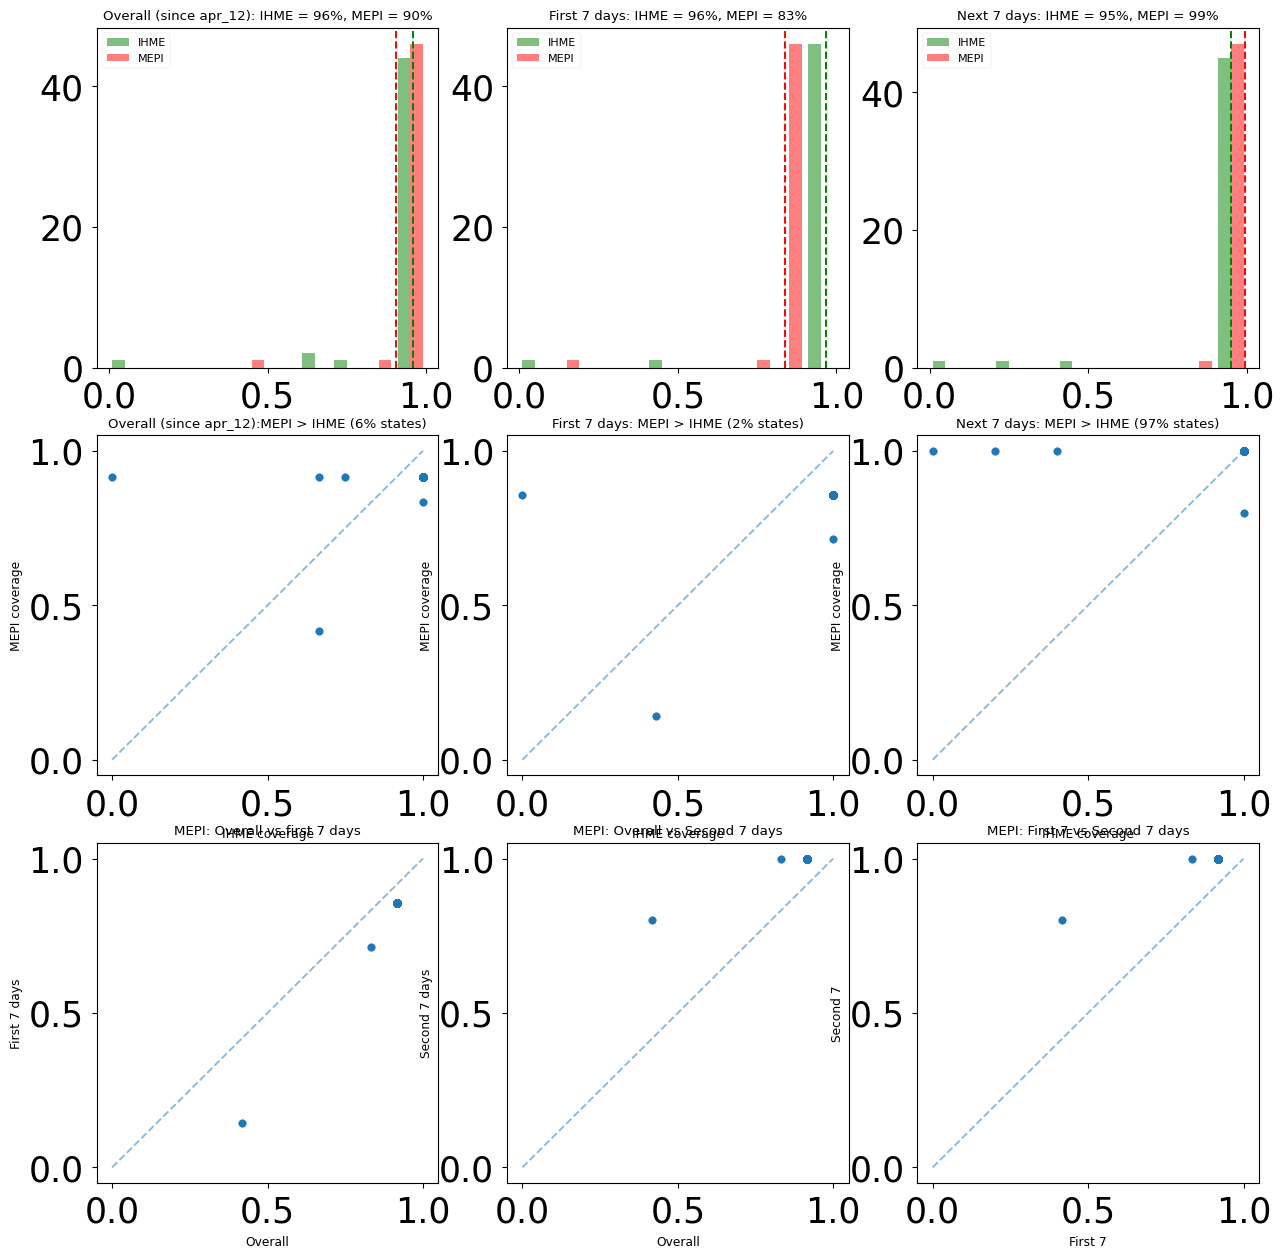

In [1575]:

tadd = int(7)
l = pred_start_idx+1+max(w-shift, 0)
plt.figure(figsize=[15, 15])
plt.subplot(3, 3, 1)
plt.hist([model_coverage[:, l:].mean(axis=1), mepi_coverage[:, l:].mean(axis=1)],label=['IHME', 'MEPI'], color=['g', 'r'], alpha=0.5)
plt.axvline(mepi_coverage[:, l:].mean(), linestyle='--', color='r')
plt.axvline(model_coverage[:, l:].mean(), linestyle='--' ,color='g')
plt.legend()
plt.title('Overall (since %s): IHME = %d%%, MEPI = %d%%'%(file_name[:-4], 100*model_coverage[:, l:].mean(), 100*mepi_coverage[:, l:].mean()))

plt.subplot(3, 3, 4)
plt.scatter(model_coverage[:, l:].mean(axis=1), mepi_coverage[:, l:].mean(axis=1))
plt.xlabel('IHME coverage')
plt.ylabel('MEPI coverage')
plt.plot([0, 1], [0, 1], linestyle='--', alpha=.5)
plt.title('Overall (since %s):MEPI > IHME (%d%% states)'%(file_name[:-4], 100*np.mean(model_coverage[:, l:].mean(axis=1) <= mepi_coverage[:, l:].mean(axis=1))))

r = l+tadd
plt.subplot(3, 3, 2)
plt.hist([model_coverage[:, l:r].mean(axis=1), mepi_coverage[:, l:r].mean(axis=1)],label=['IHME', 'MEPI'], color=['g', 'r'], alpha=0.5)
plt.axvline(mepi_coverage[:, l:r].mean(), linestyle='--', color='r')
plt.axvline(model_coverage[:, l:r].mean(), linestyle='--' ,color='g')
plt.legend()
plt.title('First %d days: IHME = %d%%, MEPI = %d%%'%(tadd, 100*model_coverage[:, l:r].mean(), 100*mepi_coverage[:, l:r].mean()))

plt.subplot(3, 3, 5)
plt.scatter(model_coverage[:, l:r].mean(axis=1), mepi_coverage[:, l:r].mean(axis=1))
plt.xlabel('IHME coverage')
plt.ylabel('MEPI coverage')
plt.plot([0, 1], [0, 1], linestyle='--', alpha=.5)
plt.title('First %d days: MEPI > IHME (%d%% states)'%(tadd, 100*np.mean(model_coverage[:, l:r].mean(axis=1) <= mepi_coverage[:, l:r].mean(axis=1))))

l = r
r = l+tadd*2
plt.subplot(3, 3, 3)
plt.hist([model_coverage[:, l:r].mean(axis=1), mepi_coverage[:, l:r].mean(axis=1)],label=['IHME', 'MEPI'], color=['g', 'r'], alpha=0.5)
plt.axvline(mepi_coverage[:, l:r].mean(), linestyle='--', color='r')
plt.axvline(model_coverage[:, l:r].mean(), linestyle='--' ,color='g')
plt.legend()
plt.title('Next %d days: IHME = %d%%, MEPI = %d%%'%(tadd, 100*model_coverage[:, l:r].mean(), 100*mepi_coverage[:, l:r].mean()))

plt.subplot(3, 3, 6)
plt.scatter(model_coverage[:, l:r].mean(axis=1), mepi_coverage[:, l:r].mean(axis=1))
plt.xlabel('IHME coverage')
plt.ylabel('MEPI coverage')
plt.plot([0, 1], [0, 1], linestyle='--', alpha=.5)
plt.title('Next %d days: MEPI > IHME (%d%% states)'%(tadd, 100*np.mean(model_coverage[:, l:r].mean(axis=1) <= mepi_coverage[:, l:r].mean(axis=1))))


l = pred_start_idx+1+max(w-shift, 0)
plt.subplot(3, 3, 7)
plt.scatter(mepi_coverage[:, l:].mean(axis=1), mepi_coverage[:, l:l+tadd].mean(axis=1))
plt.xlabel('Overall')
plt.ylabel('First %d days'%(tadd))
plt.plot([0, 1], [0, 1], linestyle='--', alpha=.5)
plt.title('MEPI: Overall vs first %d days'%(tadd))



plt.subplot(3, 3, 8)
plt.scatter(mepi_coverage[:, l:].mean(axis=1), mepi_coverage[:, l+tadd:l+2*tadd].mean(axis=1))
plt.xlabel('Overall')
plt.ylabel('Second %d days'%(tadd))
plt.plot([0, 1], [0, 1], linestyle='--', alpha=.5)
plt.title('MEPI: Overall vs Second %d days'%(tadd))

plt.subplot(3, 3, 9)
plt.scatter(mepi_coverage[:, l:l+15].mean(axis=1), mepi_coverage[:, l+tadd:l+tadd*2].mean(axis=1))
plt.xlabel('First %d'%tadd)
plt.ylabel('Second %d'%tadd)
plt.plot([0, 1], [0, 1], linestyle='--', alpha=.5)
plt.title('MEPI: First %d vs Second %d days'%(tadd, tadd))



# plt.tight_layout()
plt.show()


### State Coverage

In [1576]:
# plt.style.available
# plt.rcdefaults()
# plt.style.use('seaborn-paper')

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# # rc('font',**{'family':'serif','serif':['Helvetica']})
# # rc('text', usetex=True)


# import matplotlib as mpl
# label_size = 20
# mpl.rcParams['xtick.labelsize'] = label_size 
# mpl.rcParams['ytick.labelsize'] = label_size 

# c1 = sns.color_palette()[0]
# c2 = sns.color_palette()[2]

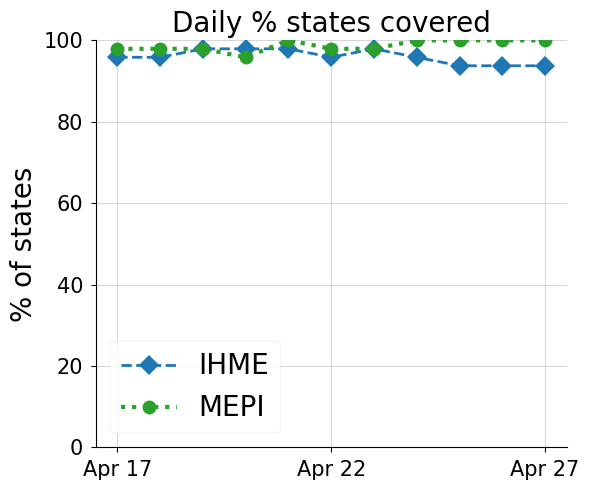

In [1577]:
x0 = t0+1
xaxis = np.arange(x0, model_coverage.shape[1])
plt.figure(figsize=[6,5])
plt.plot(xaxis, 100*model_coverage.mean(axis=0)[x0:], label='IHME', marker='D', linestyle='--',color=c1, markersize=10, linewidth=2.)
plt.plot(xaxis[:], 100*mepi_coverage.mean(axis=0)[x0:], label='MEPI', marker='o', linestyle=':',color=c2, markersize=10, linewidth=3.)
xticks = np.arange(x0, model_coverage.shape[1], 5)
xlabs = [(date_init+timedelta(days=int(t))).strftime('%b %d') for t in xticks]
plt.xticks(xticks, xlabs, fontsize=15)
plt.yticks(np.arange(0, 120, 20), np.arange(0, 120, 20), fontsize=15)
plt.legend(fontsize=20)
plt.ylim([0, 100])
# plt.xlabel('Date')
plt.ylabel('% of states', fontsize=20)
# plt.title('Average states covered daily with time (w=%d, shift=%d, method=%s, factor=%.2f)'%(w, shift, method, factor))
plt.title('Daily % states covered', fontsize=20)
plt.grid(True, alpha=.5)
plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig('daily_coverage_%s.pdf'%(file_name[:-4]))
plt.show()

In [1578]:
100*model_coverage[:, l:].mean(axis=1), new_df["state"][np.where(100*model_coverage[:, l:].mean(axis=1)<90)[0]].index

(array([100.        , 100.        , 100.        , 100.        ,
         66.66666667, 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        ,  75.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        ,   0.        , 100.        ,
        100.        , 100.        , 100.        ,  66.66666667]),
 Int64Index([4, 15, 42, 47], dtype='int64'))

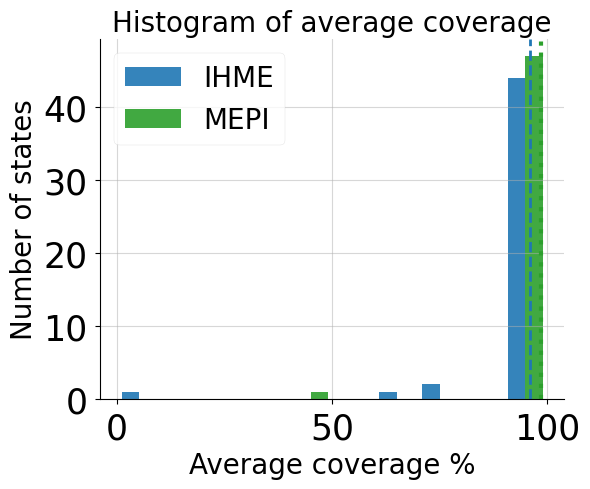

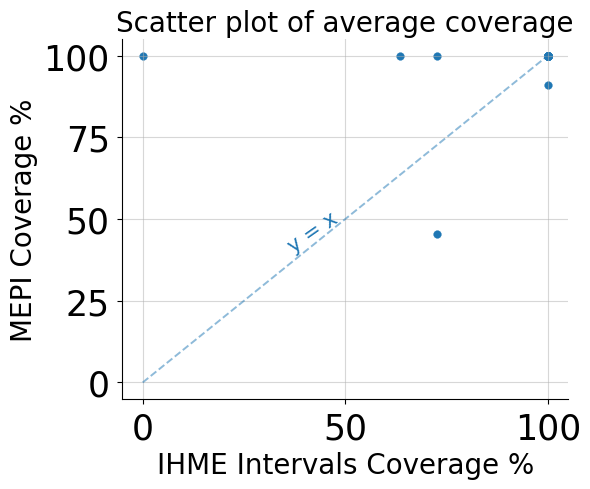

In [1579]:
plt.figure(figsize=[6, 5])
# l = pred_start_idx+1+max(w-shift, 0)
l = t0+1
plt.hist([100*model_coverage[:, l:].mean(axis=1), 100*mepi_coverage[:, l:].mean(axis=1)],label=['IHME', 'MEPI'], color=[c1, c2], alpha=0.9)
plt.axvline(100*model_coverage[:, l:].mean(), linestyle='--' ,color=c1, linewidth=2.,)
plt.axvline(100*mepi_coverage[:, l:].mean(), linestyle=':', color=c2, linewidth=3.,)

if file_name=='mar_25.csv':
    plt.text(x=60, y=11, s='(IHME Avg. = %d%%)'%(100*model_coverage[:, l:].mean())
             , rotation=0, fontsize=15, color=c1)
    plt.text(x=60, y=12.5, s='(MEPI Avg. = %d%%)'%(100*mepi_coverage[:, l:].mean())
             , rotation=0, fontsize=15, color=c2)

if file_name=='apr_5.csv':
    plt.text(x=36.5, y=7, s='(IHME Avg. = %d%%)'%(100*model_coverage[:, l:].mean())
             , rotation=90, fontsize=15, color=c1)
    plt.text(x=49.5, y=7, s='(MEPI Avg. = %d%%)'%(100*mepi_coverage[:, l:].mean())
             , rotation=90, fontsize=15, color=c2)

# plt.yticks([0, 5, 10, 15], [0, 5, 10, 15])
plt.ylabel('Number of states', fontsize=20)
plt.xlabel('Average coverage %', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True, alpha=.5)
plt.title('Histogram of average coverage', fontsize=20)
plt.tight_layout()
plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

plt.savefig('histogram_coverage_%s.pdf'%(file_name[:-4]))
plt.show()


fig, ax = plt.subplots(figsize=[6, 5])
for item in [fig, ax]:
    item.patch.set_visible(False)
# plt.figure(figsize=[8, 8])
plt.scatter(100*model_coverage[:, l:].mean(axis=1), 100*mepi_coverage[:, l:].mean(axis=1))
plt.xlabel('IHME Intervals Coverage %', fontsize=20)
plt.ylabel('MEPI Coverage %', fontsize=20)
plt.plot([0, 100], [0, 100], linestyle='--', alpha=.5)
plt.text(x=35, y=40, s='y = x', rotation=35, fontsize=15, color=sns.color_palette()[0])
plt.title('Scatter plot of average coverage', fontsize=20)
plt.tight_layout()
plt.grid(True, alpha=.5)
plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)
plt.savefig('scatter_coverage_%s.pdf'%(file_name[:-4]))
plt.show()


In [1580]:
np.stack(new_df['m_del_max'])[:, t0+w:].mean(), np.stack(new_df['ihme_del'])[:, t0+w:].mean()

(0.37487088414950037, 2.177223633624911)

In [1581]:
colors = sns.color_palette()

c_idx = np.zeros((len(new_df),len(new_df.m_del_max[0]), 3))
values = dict()
for k in range(4):
    values[k] = []
for i in range(len(new_df)):
    for j in range(t0+w, len(new_df.m_del_max[0])):
        if model_coverage[i,j] and mepi_coverage[i,j]:
            c_idx[i, j, :] = colors[0]
            values[0].append([new_df.m_del_max[i][j],new_df.ihme_del[i][j]])
        elif model_coverage[i,j] and not mepi_coverage[i,j]:
            values[1].append([new_df.m_del_max[i][j],new_df.ihme_del[i][j]])
        elif not model_coverage[i,j] and mepi_coverage[i,j]:
            values[2].append([new_df.m_del_max[i][j],new_df.ihme_del[i][j]])
        elif not model_coverage[i,j] and not mepi_coverage[i,j]:
            values[3].append([new_df.m_del_max[i][j],new_df.ihme_del[i][j]])
            
for k in range(4):
    values[k] = np.asarray(values[k])

      

In [1582]:
label_size = 25
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


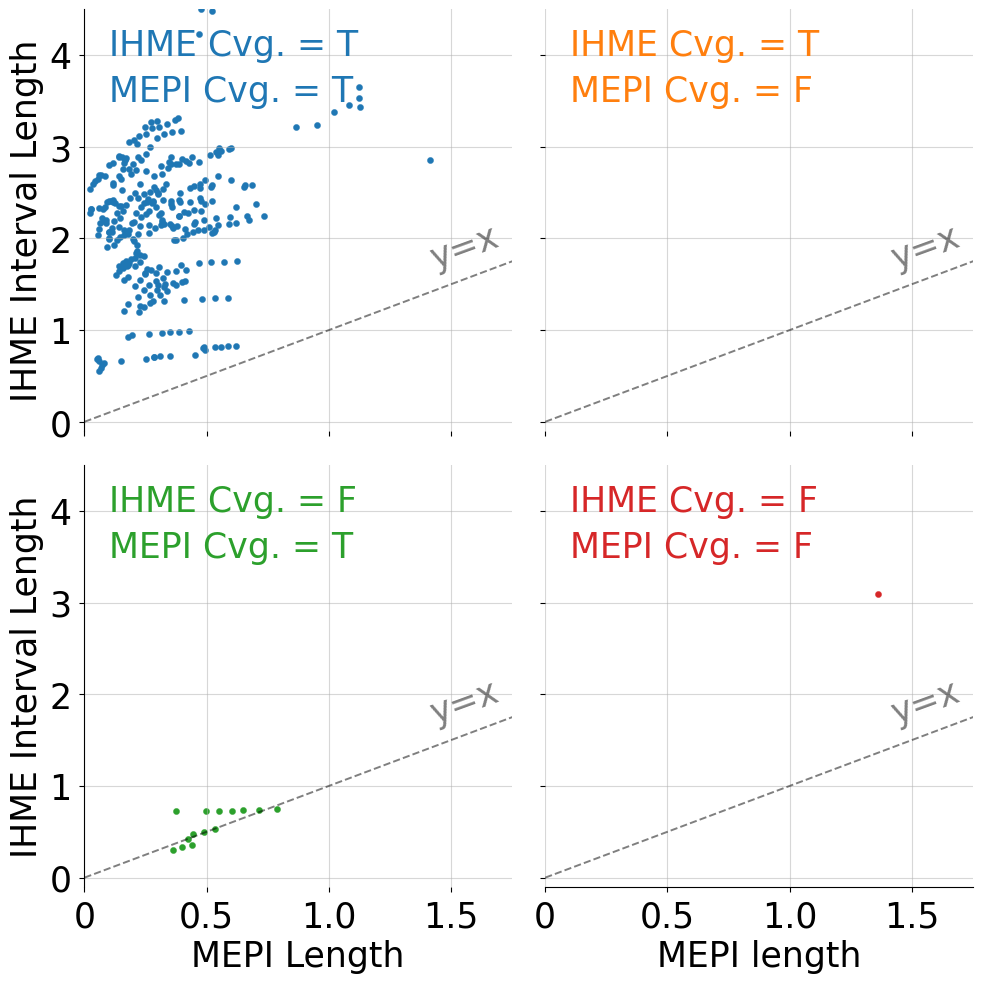

In [1583]:
fs = 25
rot = 20
s = 20
fig, axes = plt.subplots(2, 2, figsize=[10, 10], sharex=True, sharey=True)
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.scatter(values[k][:, 0], values[k][:, 1], color=colors[k], s=s)
#     xlim = plt.gca().get_xlim()
#     plt.plot(plt.gca().get_ylim(), plt.gca().get_ylim(), 'k--', alpha=0.5)
    plt.plot([0, 2], [0, 2], 'k--', alpha=0.5)
    plt.ylim([-0.1, 4.5])
    plt.xticks([0, 0.5, 1., 1.5, 2.], [0, 0.5, 1., 1.5, 2.])
    plt.grid(True, alpha=0.5)
    plt.xlim([0., 1.75])
    plt.text(x=1.4, y=1.68, rotation=rot, s = 'y=x', fontsize=fs, color='k', alpha=0.5)
    if k == 0:
        plt.gca().spines["top"].set_visible(False)  
        plt.gca().spines["right"].set_visible(False)  
        plt.gca().spines["bottom"].set_visible(False)
        plt.gca().set_xticklabels([])
        plt.text(x=0.1, y=4, s = 'IHME Cvg. = T', fontsize=fs, color=colors[k])
        plt.text(x=0.1, y=3.5, s = 'MEPI Cvg. = T', fontsize=fs, color=colors[k])
        
        plt.ylabel('IHME Interval Length', fontsize=fs)
    if k == 1:
        plt.gca().spines["top"].set_visible(False)  
        plt.gca().spines["right"].set_visible(False)  
        plt.gca().spines["left"].set_visible(False)
        plt.gca().spines["bottom"].set_visible(False)
        plt.text(x=0.1, y=4, s = 'IHME Cvg. = T', fontsize=fs, color=colors[k])
        plt.text(x=0.1, y=3.5, s = 'MEPI Cvg. = F', fontsize=fs, color=colors[k])
        
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        

    if k == 2:
        plt.gca().spines["top"].set_visible(False)  
        plt.gca().spines["right"].set_visible(False)  
#         plt.gca().spines["left"].set_visible(False)
        plt.gca().spines["bottom"].set_visible(False)
        plt.text(x=0.1, y=4, s = 'IHME Cvg. = F', fontsize=fs, color=colors[k])
        plt.text(x=0.1, y=3.5, s = 'MEPI Cvg. = T', fontsize=fs, color=colors[k])
        
#         plt.gca().set_xticklabels([])
#         plt.gca().set_yticklabels([])
        plt.xlabel('MEPI Length', fontsize=fs)
        plt.ylabel('IHME Interval Length', fontsize=fs)
    if k == 3:
        plt.gca().spines["top"].set_visible(False)  
        plt.gca().spines["right"].set_visible(False)  
        plt.gca().spines["left"].set_visible(False)
        plt.text(x=0.1, y=4, s = 'IHME Cvg. = F', fontsize=fs, color=colors[k])
        plt.text(x=0.1, y=3.5, s = 'MEPI Cvg. = F', fontsize=fs, color=colors[k])
        
#         plt.gca().spines["bottom"].set_visible(False)
#         plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.xlabel('MEPI length', fontsize=fs)
#     plt.xti
plt.tight_layout()
plt.savefig('length_%s.pdf'%(file_name[:-4]))
plt.show()  